# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.

    POSSIBLE STEPS TO FOLLOW
    - feature engineering
    - log transform on targets to normalize
    - define find next predictor func in credit balance lab
    - run that func on split data
    - scale split dfs and convert back to dfs since scaling makes them arrays
    - run the func again on scaled data and see if theres any differences?
    - choose predictors
    - 10-fold cross validation
4. Which of the 3 target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest prediction accuracy on the test set? Why is this? __[5 marks]__

Use log transform to deal with data spread of data
https://www.google.com/search?q=how+to+deal+with+data+skewness&oq=how+to+deal+with+data+skewness&aqs=chrome..69i57.4029j0j7&sourceid=chrome&ie=UTF-8

- log transformation

# Task 1: Read the _hourly_ data and split into training and test data.

In [649]:
import numpy as np
import pandas as pd
import seaborn as sns
import phik
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

hourly = pd.read_csv('./data/hour.csv')
daily = pd.read_csv('./data/day.csv')
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Glancing at the Non-Nulls, it looks that there are no NANs in the data, so this will not need to be explored in the EDA phase.

Before I split into train and test data, I'd like to rename the columns so the're clearer. This should most likely be done in Task 2 as part of EDA data pre-processing, but we can do it here so that our train and test data all use the same column names.

In [650]:
hourly.rename(columns={'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'workingday': 'working_day', 'weathersit': 'weather_situation', 'atemp': 'feels-like-temp', 'hum': 'humidity', 'cnt': 'bike_count', 'weekday': 'day_of_week'}, inplace=True)
hourly.head(1)

,instant,date,season,year,month,hour,holiday,day_of_week,working_day,weather_situation,temp,feels-like-temp,humidity,windspeed,casual,registered,bike_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16


In [651]:
from sklearn.model_selection import train_test_split

# Splitting features and targets
targets = hourly[['bike_count', 'registered', 'casual']]

features = hourly.drop(targets, axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(features, targets, test_size=0.2)
train_df = pd.merge(xtrain, ytrain, left_index=True, right_index=True) # using this to plot training data

xtrain.head(3)

,instant,date,season,year,month,hour,holiday,day_of_week,working_day,weather_situation,temp,feels-like-temp,humidity,windspeed
9198,9199,2012-01-24,1,1,1,4,0,2,1,2,0.30,0.3182,1.00,0.0896
3323,3324,2011-05-23,2,0,5,9,0,1,1,1,0.60,0.5455,0.88,0.2239
1027,1028,2011-02-15,1,0,2,12,0,2,1,1,0.28,0.2727,0.24,0.2537


# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model
In order to structure the EDA in an appropriate manner, I will follow the same format followed in Assignment One and take the analysis in three passes:
<br>

 1. First pass - load data set and initial clean <br> <br>
 2. Second pass - individual features and target <br> <br>
 3. Third pass - relationships between features and target

In [652]:
print("Features: ", xtrain.columns.tolist()) ## the features in question

print("Targets: ", ytrain.columns.tolist()) ## the targets in question

Features:  ['instant', 'date', 'season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed']
Targets:  ['bike_count', 'registered', 'casual']


## Pass One

### Duplicates & NAs

In [653]:
print('Num of duplicates: {}'.format(train_df.duplicated().sum()))

Num of duplicates: 0


In [654]:
nullvalues = (train_df.isna().sum()/train_df.shape[0])*100
nullvalues # Percentage of missing values in columns

instant              0.0
date                 0.0
season               0.0
year                 0.0
month                0.0
hour                 0.0
holiday              0.0
day_of_week          0.0
working_day          0.0
weather_situation    0.0
temp                 0.0
feels-like-temp      0.0
humidity             0.0
windspeed            0.0
bike_count           0.0
registered           0.0
casual               0.0
dtype: float64

Since the dataset contains no missing or duplicate values, then there is no need to perform any additional cleaning or preprocessing steps. Also, the columns have already been renamed and are in a state now that we can begin to examine the data to learn more about it.

**Note**: Before I move onto pass two I would like to drop the **instant** feature since it is of no use to me!

In [655]:
xtrain.drop('instant', inplace=True, axis=1)
xtest.drop('instant', inplace=True, axis=1)
print("Features without Instant: ", xtrain.columns.tolist()) ## the features in question

Features without Instant:  ['date', 'season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed']


## Pass Two
To make pass two a bit easier I am going to examine the features in three groups.

- Date, Season, Year, Month, Hour, Holiday, Day of the Week and Working day can all fit under a category named **Calendar Information**
- Weather Situation, temperature, feels like temperature, humidity and windspeed can all fit under a category named **Weather Information**

### Calendar Information Features
To further simplify the EDA and put feature analysis into context, I'll group them as I see fit and perform multi-variate analysis immediately instead of performing single-variate analysis on every feature.

#### Features: Date, Year, & Holiday

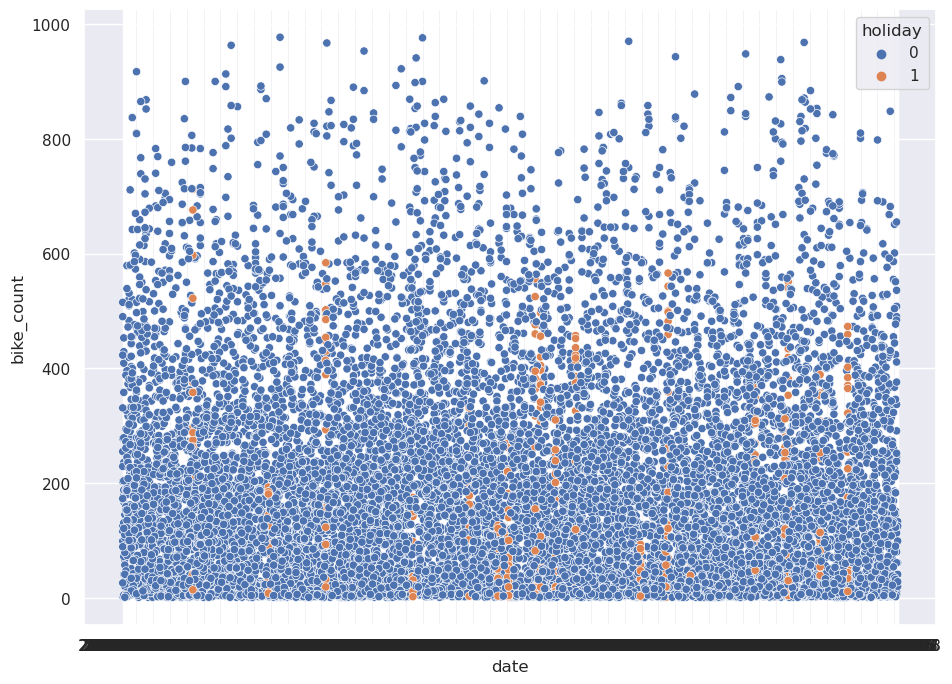

In [656]:
sns.scatterplot(x='date', y='bike_count', data=train_df, hue='holiday')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

From the above, we can see that during 2011, it looks there were a much smaller number of bicycles being rented per hour in total. We can also see that days that were holidays vs those that weren't were much lower. As a small conclusion from this scatter plot, we can derive 2012 had much more bikes being rented, the start of the year generally has a far lower number of bikes being rented which begins to rise around April. It also starts to drop off slightly again around October in both years.

As it is difficult to see the holiday details lets plot that alone.

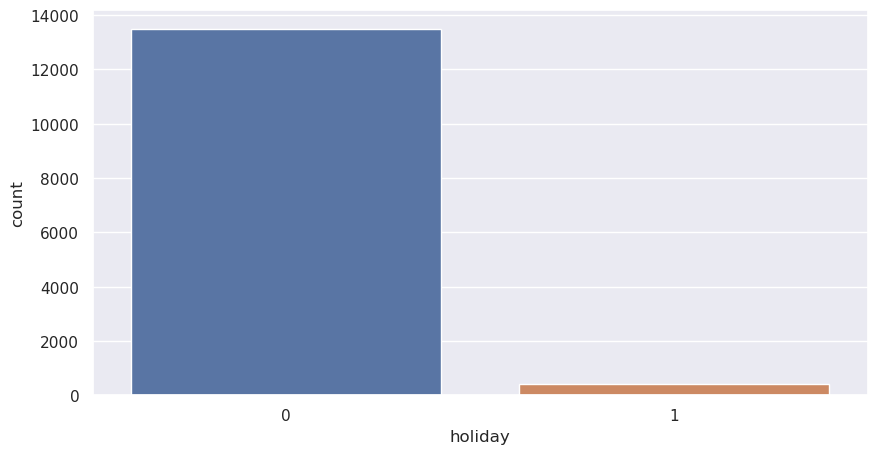

In [657]:
sns.countplot(x='holiday', data=train_df)
plt.rcParams['figure.figsize'] = [5, 2]
plt.show()

Clearly, we can see that the ratio of days that weren't holidays to days that were is very one-sided.

In [658]:
ytrain_holiday_1 = ytrain.loc[xtrain["holiday"] == 1]
average_bike_count_1 = ytrain_holiday_1["bike_count"].mean()
ytrain_holiday_0 = ytrain.loc[xtrain["holiday"] == 0]
average_bike_count_0 = ytrain_holiday_0["bike_count"].mean()

print(f'Average bike count when holiday == 0 is {average_bike_count_0} and average bike count when holiday == 1 is {average_bike_count_1}')

Average bike count when holiday == 0 is 190.97755721798384 and average bike count when holiday == 1 is 156.044776119403


This skew wont aid us much as when it is not a holiday, more bikes are rented. While it could be a slightly good predictor, given that there are so few holidays we will probably drop this feature during the feature engineering section in Task 3.

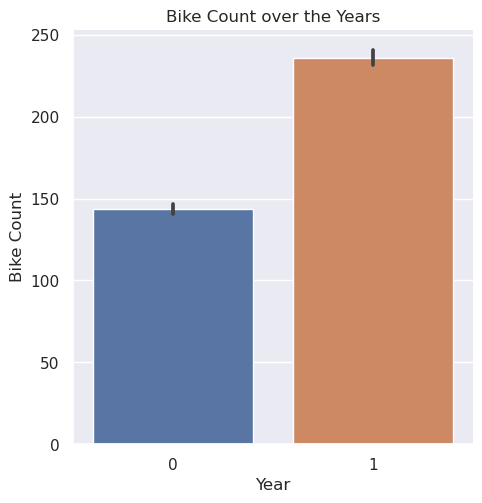

In [659]:
sns.catplot(x='year', y='bike_count', data=train_df, kind='bar')

plt.title("Bike Count over the Years")
plt.xlabel("Year")
plt.ylabel("Bike Count")
plt.show()

Again, the above barplot shows that more bikes can be seen to have been rented during 2012 when compared to 2011. This will likely be a good predictor. As Month, Date, Year, all kind of say the same thing and will likely be highly correlated in EDA pass 3, some of these will likely be dropped. I suspect I will drop date as it has too much information in one feature. Year can be kept as it seems to be a significant predictor and date and holiday will then be dropped!

#### Features: Season & Month
Season and Month are largely the same, where month has 12 options, season has 4 so I will most likely remove one of these but I'd like to see which would be the better predictor.

From the plot below, during each season it looks as though during Summer (3) the variance between each month is not that significant as to be expected. During the ther months though, within each season, the average hourly bikes rented varies quite a bit. This might mean that month could be a better choice. As an example to explain my thought process here - say there are two rows, both of which are in Spring (2) and one at the start and one at the end. With just season, we don't get a clear picture of average bike count. But if we can say the start of Spring we can expect far less than the end of Spring, this would provide much more valuable context. Thus, month is a better predictor.

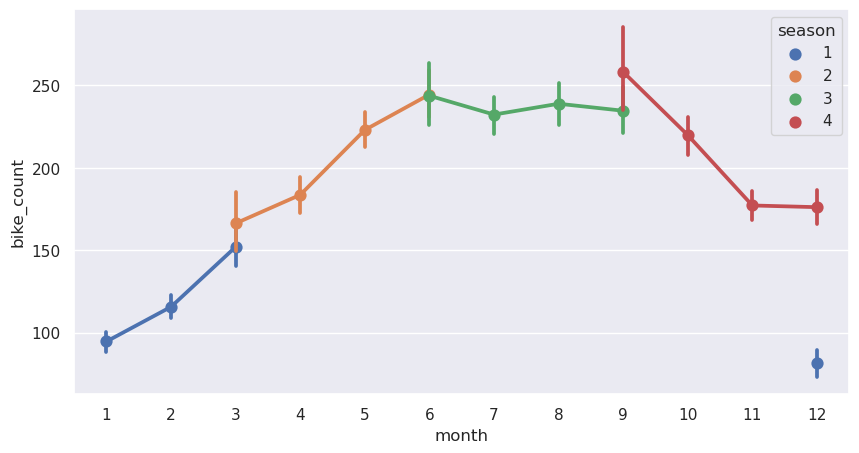

In [660]:
plt.figure(figsize=(10,5))
sns.pointplot(x="month", y="bike_count", hue="season", data=train_df)
plt.show()

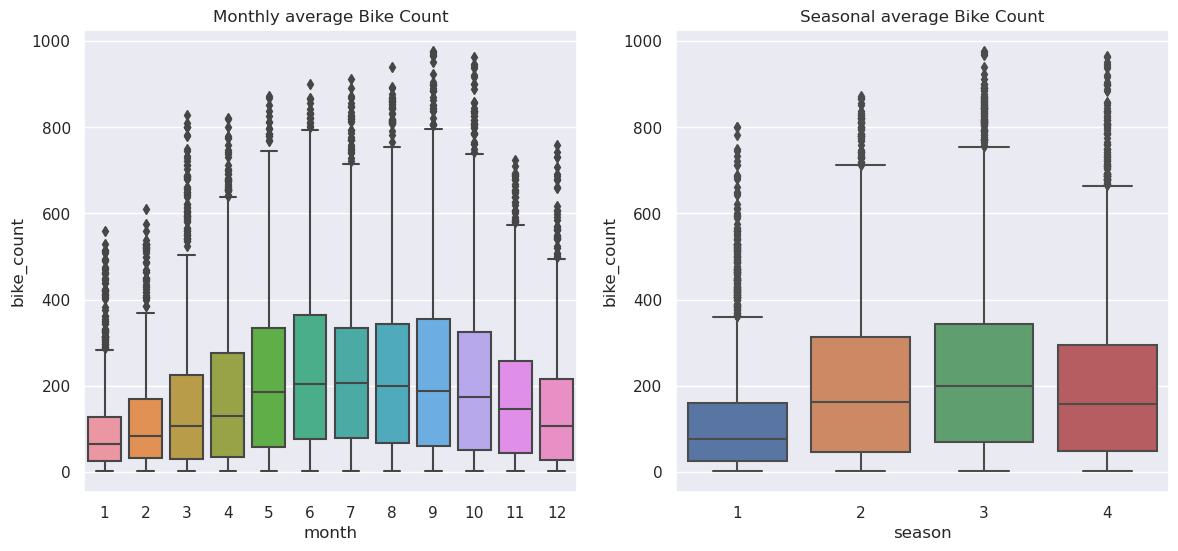

In [661]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x="month", y="bike_count", data=train_df, ax=ax1)
ax1.set_title('Monthly average Bike Count')

sns.boxplot(x="season", y="bike_count", data=train_df, ax=ax2)
ax2.set_title('Seasonal average Bike Count')

plt.show()

The above plot confirms what was discussed in the previous markdown cell. The right hand plot shows that the variance in bike count does not vary a lot during Spring Summer and Autumn but it does in Winter (expected as weather is worse in Winter). But with month we see a far more accurate picture where the average bike count gradually increases during the early months, peaks in summer, and starts to decline again as it approaches the end of the year.

After revisiting this at a later date.. I've decided that in order to avoid bias I am going to drop month instead of season, and split season into 4 separate features. This will allow me to say that summer is a great predictor but winter isnt, using them as separate features entirely.

#### Features: Day of The Week, Working day, & Hour

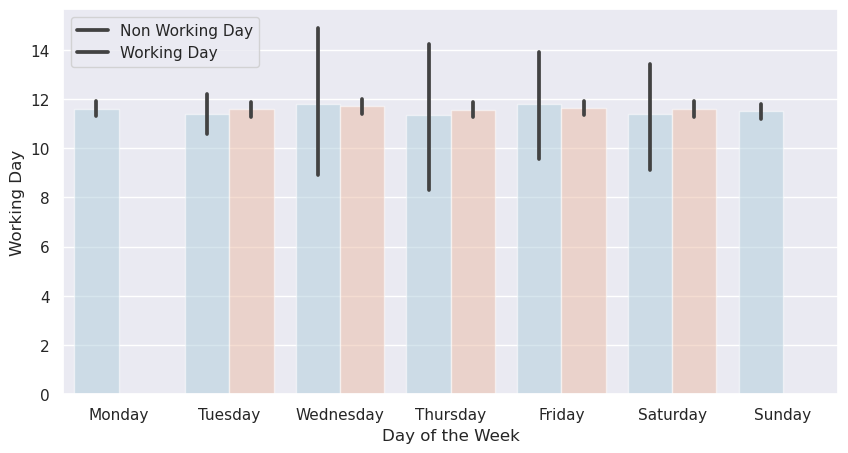

In [662]:
plt.figure(figsize=(10,5))
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='day_of_week', y='hour', hue='working_day', data=train_df, palette='RdBu_r', alpha=0.5)
plt.xticks(range(7), days_of_the_week)
plt.legend(labels=['Non Working Day', 'Working Day'])
plt.xlabel("Day of the Week")
plt.ylabel('Working Day')
plt.show()

It appears that there are more bike rentals on weekdays (Monday through Friday) than on weekends (Saturday and Sunday). This could be because people are more likely to use a bike for commuting on weekdays, while they may be more likely to use a car or public transportation on weekends.

One interesting insight that can be derived from the plot is that there is a spike in bike rentals on Thursday and Friday. This could be because people are more likely to use a bike for leisure activities on the weekends, and so they may rent a bike on Thursday or Friday to use for the weekend.

Due to working day being quite redundant with the present of day of the week, I will drop that. Also, I am going to split day of the week into separate features to reduce bias as friday could be a great predictor for the targets but the other days might not!

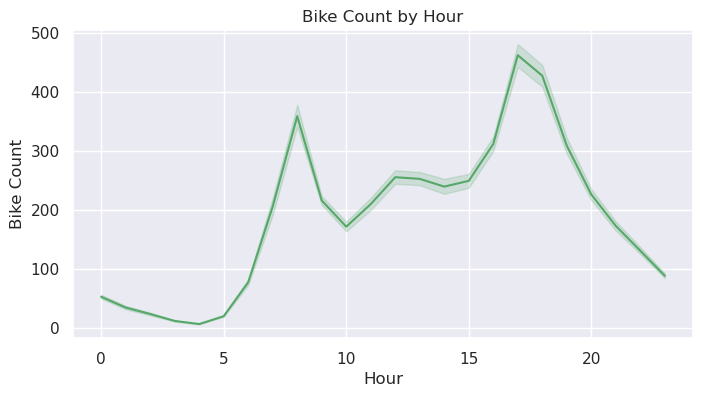

In [663]:
plt.figure(figsize=(8,4))
sns.lineplot(x="hour", y="bike_count", data=train_df, color='g')

plt.title("Bike Count by Hour")
plt.xlabel("Hour")
plt.ylabel("Bike Count")

plt.show()

The plot shows that the number of bike rentals is highest during the morning and evening hours, when people are likely to use a bike for commuting to and from work. The plot also shows spikes in bike rentals during the middle of the day and late afternoon, indicating that people may be using bikes for leisure activities during these times. Additionally, the plot shows that the number of bike rentals is highest during the early morning hours, around 7-8am, and the late afternoon hours, around 5-6pm, suggesting that people are using bikes for commuting during these times. It is likely that this feature will prove to be a good predictor.

### Weather Information Features

#### Features: Temperature & Feels like Temperature,

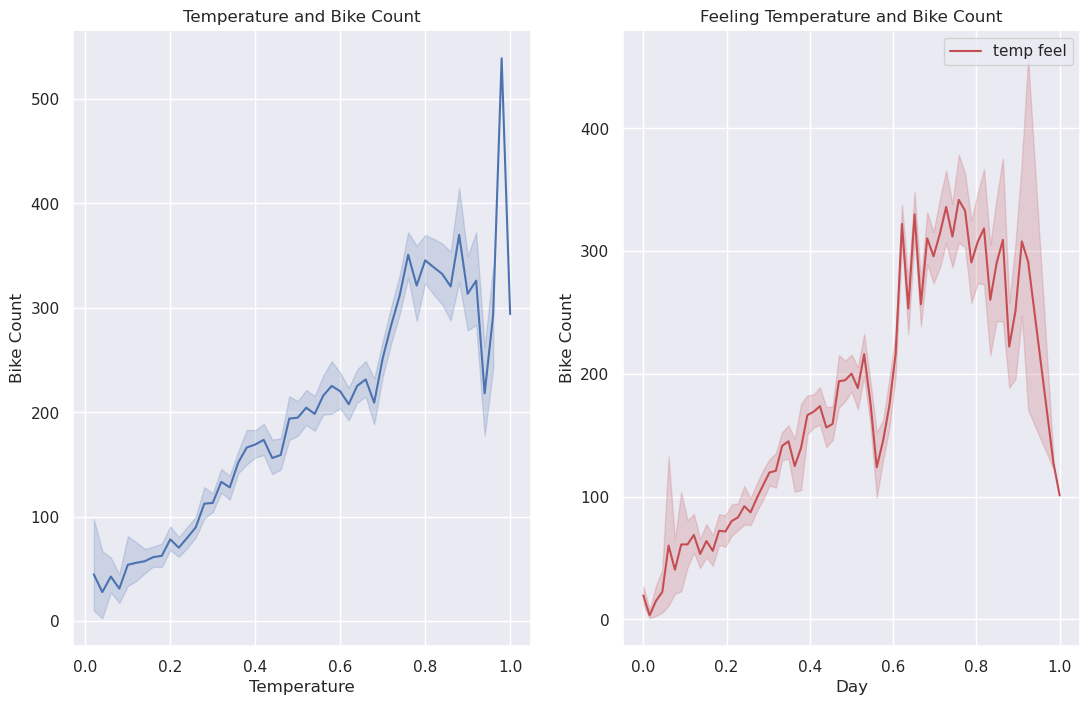

In [664]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.lineplot(x='temp', y='bike_count', data=train_df, ax=ax[0])
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Bike Count')
ax[0].set_title('Temperature and Bike Count')

# plot atemp and bike count on one plot
sns.lineplot(x='feels-like-temp', y='bike_count', data=train_df, label='temp feel', color='r', ax=ax[1])
ax[1].set_title('Feeling Temperature and Bike Count')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Bike Count')

plt.show()

These features are fairly self explanatory. The normalised actual and feeling temperatures. As the graphs above suggest, the lower temperatures tend to have far less people hiring bikes. The higher temperatures have more but there's a steep drop off near the high end of the graphs. There will be no need to keep two of these features as they are clearly closely related and likely highly correlated. I will actually drop the temperature (not atemp, or now feels-like-temp) as the feels like temp will be more of an indication of whether people will rent bikes as it is what people feel and people tend to act on feelings instead of the temperature. This will likely also be a strong predictor.

#### Features: Weather Situation, Humidity, & Windspeed

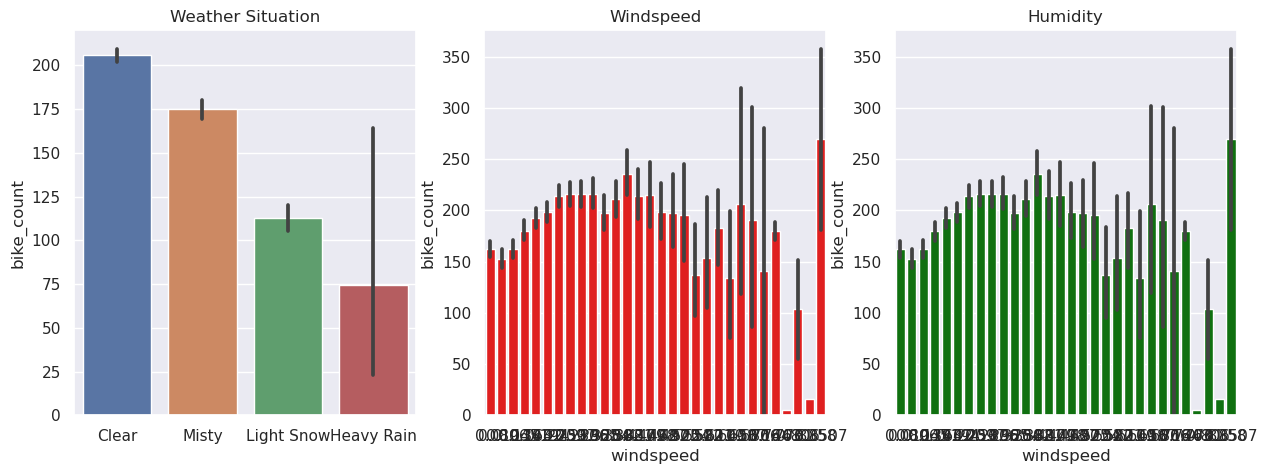

In [665]:
# Setting up the figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

labels = ['Clear', 'Misty', 'Light Snow', 'Heavy Rain']

# Plot #1: Weather Situation
sns.barplot(data=train_df, x='weather_situation', y='bike_count', ax=ax1)
ax1.set_title('Weather Situation')
ax1.set_xticks(range(4), labels)
ax1.set_xlabel("")

# Plot #2: Windspeed
sns.barplot(data=train_df, x='windspeed', y='bike_count', ax=ax2,color="red")
ax2.set_title('Windspeed')

# Plot #3: Humidity
sns.barplot(data=train_df, x='windspeed', y='bike_count', ax=ax3, color="green")
ax3.set_title('Humidity')

plt.show()

From the above we can derive the following insights:
- The weather situation has some clear indication of the number of bike rentals. Light snow and heavy rain have far less bike rentals than misty and clear weather
- The windspeed and humidity data is quite sporadic and difficult to interpret from these plots so lets do some further examination.

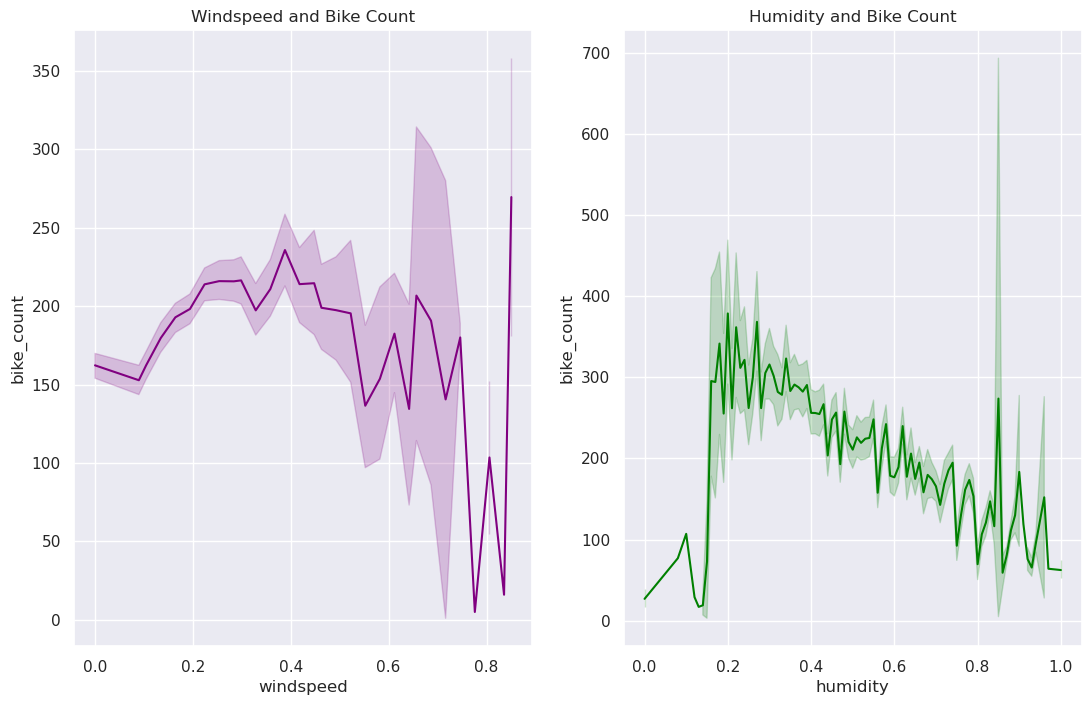

In [666]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.lineplot(x='windspeed', y='bike_count', data=train_df, ax=ax[0], color='purple')
ax[0].set_title('Windspeed and Bike Count')

sns.lineplot(x='humidity', y='bike_count', data=train_df, color='green', ax=ax[1])
ax[1].set_title('Humidity and Bike Count')

plt.show()

I would suspect there to be some outliers present from how the data looks here. But, for the case of humidity: the number of bikes being rented significantly decreases the higher the level of humidity gets. The same can most likely be said for windspeed, although I would say the spike on the right hand side of that graph could be due to outliers. I will check.

<AxesSubplot:xlabel='windspeed'>

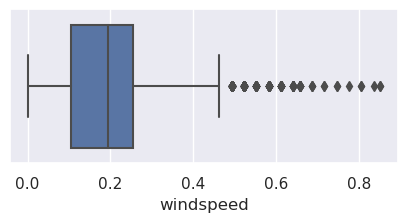

In [667]:
sns.boxplot(data=train_df, x="windspeed")

Definitely some outliers present here, since I think it does negatively affect the data, I could use log transformation or another method later to deal with them (during feature engineering).

That marks the end of pass two, onto pass 3.

## Pass Three

interval columns not set, guessing: ['instant', 'season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed', 'bike_count', 'registered', 'casual']


,instant,date,season,year,month,hour,holiday,day_of_week,working_day,weather_situation,temp,feels-like-temp,humidity,windspeed,bike_count,registered,casual
instant,1.000000,0.446375,0.806528,0.624644,0.794910,-0.331727,-0.048862,-0.238143,-0.243350,0.057335,0.741031,0.737860,0.215062,0.105446,0.143095,0.097302,0.162606
date,0.446375,1.000000,0.398859,0.206645,0.408724,-0.894738,0.370132,0.325061,0.315070,0.064453,0.203928,0.205506,-0.156102,-0.147571,-0.626726,-0.644545,-0.343581
season,0.806528,0.398859,1.000000,0.271300,0.993716,-0.309778,0.097130,-0.093195,-0.088047,0.165249,0.899496,0.901451,0.294243,0.236759,0.059325,0.002645,0.227815
year,0.624644,0.206645,0.271300,1.000000,0.249506,-0.185418,0.159003,0.069822,0.058121,0.166564,0.232719,0.226392,0.246814,0.097922,0.265647,0.274072,0.198822
month,0.794910,0.408724,0.993716,0.249506,1.000000,-0.280089,0.092591,-0.104816,-0.097459,0.150156,0.920158,0.923975,0.331013,0.244390,0.072729,0.011893,0.247906
hour,-0.331727,-0.894738,-0.309778,-0.185418,-0.280089,1.000000,-0.407916,-0.330402,-0.308370,-0.135204,-0.005449,-0.010717,0.315230,0.069608,0.786756,0.782489,0.561218
holiday,-0.048862,0.370132,0.097130,0.159003,0.092591,-0.407916,1.000000,0.622194,0.663754,0.162317,-0.020970,-0.029389,0.012534,0.041898,-0.280576,-0.259111,-0.072114
day_of_week,-0.238143,0.325061,-0.093195,0.069822,-0.104816,-0.330402,0.622194,1.000000,0.979877,0.133969,-0.124179,-0.137856,-0.025726,-0.052654,-0.217540,-0.175066,0.160157
working_day,-0.243350,0.315070,-0.088047,0.058121,-0.097459,-0.308370,0.663754,0.979877,1.000000,0.091893,-0.124573,-0.139709,-0.076944,-0.096822,-0.165186,-0.127814,0.235121
weather_situation,0.057335,0.064453,0.165249,0.166564,0.150156,-0.135204,0.162317,0.133969,0.091893,1.000000,0.128722,0.148989,0.622970,0.202073,-0.082892,-0.107377,-0.008508


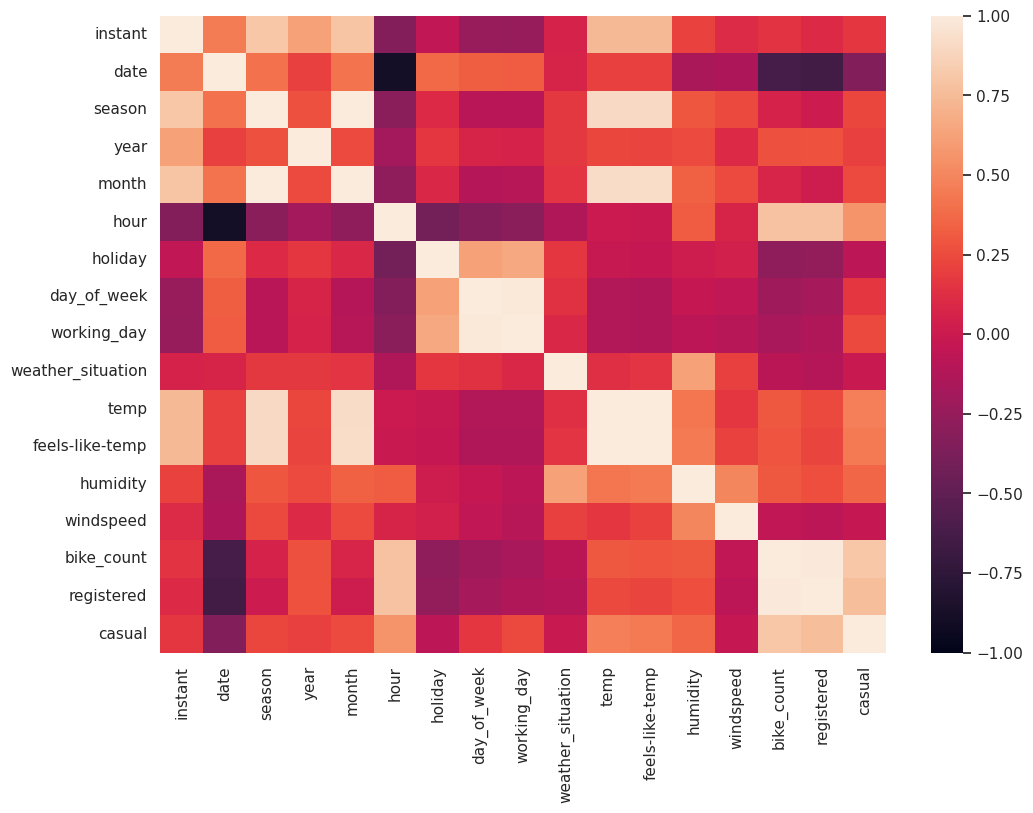

In [668]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_dataframe = phik.phik_matrix(df=train_df)
sns.heatmap(correlation_dataframe.corr(), vmin=-1, vmax=1, annot=False)
correlation_dataframe.corr()

To make EDA pass 3 a bit quicker, as I've already identified what I will most likely drop in feature engineering, I will give an overview of which features are highly correlated to which targets. This may give a better indication of what features should be dropped. ie. if two features are highly correlated with each other and there is a question of which one to drop, if one is significantly more correlated to the targets then that one should be kept. Below is a table of how correlated the features are to the targets. Lets examine this: (This was extracted from the phik matrix above)

|                       | **Bike Count** | **Registered** | **Casual** |
|:---------------------:|:--------------:|:--------------:|:----------:|
|        **date**       |    -0.627730   |    -0.639281   |  -0.359281 |
|       **season**      |    0.059453    |    0.012389    |  0.214637  |
|        **year**       |    0.268499    |    0.282824    |  0.196046  |
|       **month**       |    0.072982    |    0.020882    |  0.236883  |
|        **hour**       |    0.783824    |    0.774363    |  0.570063  |
|      **holiday**      |    -0.290288   |    -0.265950   |  -0.082216 |
|    **day_of_week**    |    -0.219941   |    -0.173733   |  0.147496  |
|    **working_day**    |    -0.170971   |    -0.129386   |  0.221224  |
| **weather_situation** |    -0.069441   |    -0.089405   |  -0.015186 |
|        **temp**       |    0.296841    |    0.236068    |  0.436657  |
|  **feels-like-temp**  |    0.287566    |    0.225315    |  0.429462  |
|      **humidity**     |    0.291050    |    0.254055    |  0.343017  |
|     **windspeed**     |    -0.071777   |    -0.094068   |  -0.046066 |

There actually looks to be few extremely high correlations between targets and features. Below are the few highly correlated features and targets
- Date is highly correlated with Bike count and registered
- Hour is highly correlated with all three targets

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

## Feature Engineering
Now we need to perform some feature engineering to increase the performance of the model to be created
First, some features need to be dropped to remove correlation. We can revisit the matrix but with the xtrain data only to view this.

interval columns not set, guessing: ['season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed']


<AxesSubplot:>

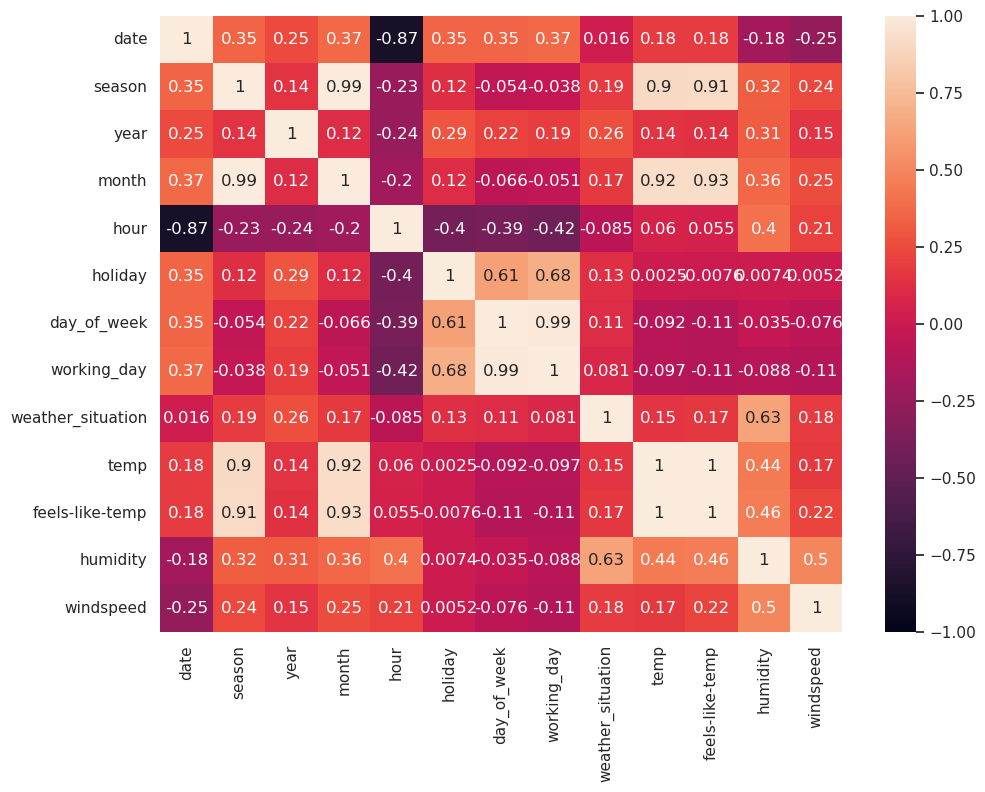

In [669]:
sns.set(rc={'figure.figsize':(11, 8)})
correlation_dataframe = phik.phik_matrix(df=xtrain)
sns.heatmap(correlation_dataframe.corr(), vmin=-1, vmax=1, annot=True)

We can clearly see that some features are highly correlated with each other. Ideally we'd like to remove this as part of the feature engineering. First, I'll recap on the features we marked for removal during EDA.
- Holiday
- Month
- Workingday

### Highly Correlated Features
- Date and Hour.
    - The data from date is quite sporadic and not refined enough. We can also derive the same information using day of the wee, year and month so date can be dropped
- Season with Month, temp and atemo.
    - Since we have already decided to drop month, that isn't an issue. I will likely drop temp as discussed in the eda as feels like temp seems to me to be a better option.
- Year is not highly correlated with anything so that can be kept!
- Month is highly correlated with (besides season) the two temp features. I will be removing feels-like-temp and will wait until I convert season to separate features.
- Weather situation is highly correlated with humidity, we will need to deal with this.
- There are other correlations but first I would like to drop the unneeded and split up the days of the week and seasons!

In [670]:
xtrain.drop(columns=['holiday', 'month', 'working_day' , 'temp', 'date'], inplace=True)
xtest.drop(columns=['holiday', 'month', 'working_day' , 'temp', 'date'], inplace=True)

### Transforming Features
Next I want to split season and day_of_week up. This can be done using the pandas get_dummies function.

#### Season
I'm going to use the below example row to test that this works correctly. I can't define exactly what the season value is here as every time this notebook is run, the train data is going to be different. I was originally running xtrain.loc[0] but oftentimes once I ran the notebook again 0 wasnt included in the training data. So here is a sample below chosen randomly. This value will need to be resassigned after changing the data frame.

In [671]:
eg = xtrain.sample()
eg

,season,year,hour,day_of_week,weather_situation,feels-like-temp,humidity,windspeed
1312,1,0,21,0,1,0.3939,0.62,0.1642


In [672]:
season_dummies = pd.get_dummies(xtrain["season"]) # Create 4 new columns from the possible values
season_dummies.columns = ["spring", "summer", "autumn", "winter"] # rename those new columns

xtrain = xtrain.join(season_dummies)

season_dummies = pd.get_dummies(xtest["season"]) # Create 4 new columns from the possible values
season_dummies.columns = ["spring", "summer", "autumn", "winter"] # rename those new columns

xtest = xtest.join(season_dummies)

In [673]:
eg = xtrain.loc[eg.index]
eg

,season,year,hour,day_of_week,weather_situation,feels-like-temp,humidity,windspeed,spring,summer,autumn,winter
1312,1,0,21,0,1,0.3939,0.62,0.1642,1,0,0,0


Spring has a value of 1 and the rest are 0 so it worked. Now to drop the old season column and do the same for day_of_week!

In [674]:
xtrain.drop(['season'], inplace=True, axis=1)
xtest.drop(['season'], inplace=True, axis=1)

In [675]:
xtrain.day_of_week.unique()

array([2, 1, 4, 0, 5, 6, 3])

#### Day of Week
Again, I'll use thew same row as seen above and will test that it has worked after splitting the feature.

In [676]:
dow_dummies = pd.get_dummies(xtrain["day_of_week"]) # Create 7 new columns from the possible values
dow_dummies.columns = ["sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday"] # rename those new columns

xtrain = xtrain.join(dow_dummies)

dow_dummies = pd.get_dummies(xtest['day_of_week']) # Create 7 new columns from the possible values
dow_dummies.columns = ["sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday"] # rename those new columns

xtest = xtest.join(dow_dummies)

In [677]:
eg = xtrain.loc[eg.index]
eg

,year,hour,day_of_week,weather_situation,feels-like-temp,humidity,windspeed,spring,summer,autumn,winter,sunday,monday,tuesday,wednesday,thursday,friday,saturday
1312,0,21,0,1,0.3939,0.62,0.1642,1,0,0,0,1,0,0,0,0,0,0


Looks like it was successful! Now we can drop the day_of_week feature and reexamine correlations.

In [678]:
xtrain.drop(['day_of_week'], inplace=True, axis=1)
xtest.drop(['day_of_week'], inplace=True, axis=1)

interval columns not set, guessing: ['year', 'hour', 'weather_situation', 'feels-like-temp', 'humidity', 'windspeed', 'spring', 'summer', 'autumn', 'winter', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']


<AxesSubplot:>

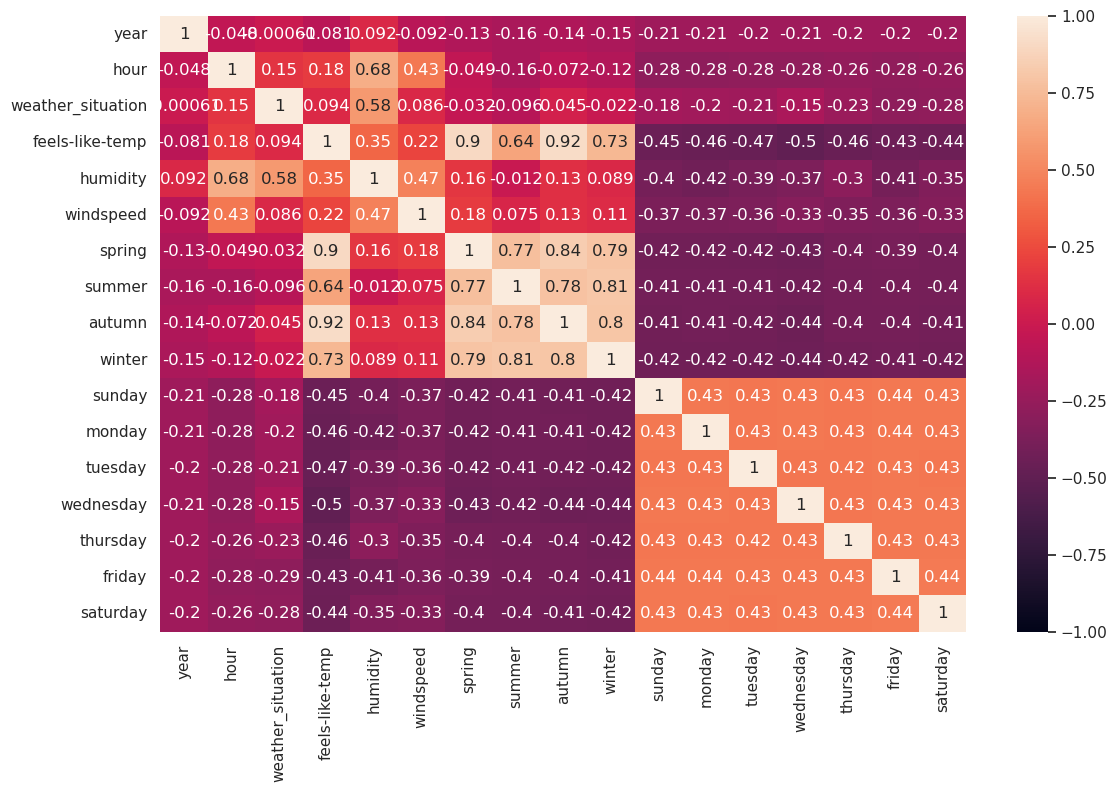

In [679]:
train_df = pd.merge(xtrain, ytrain, left_index=True, right_index=True) # using this to plot training data

plt.figure(figsize=(13, 8))
correlation_dataframe = phik.phik_matrix(df=xtrain)
sns.heatmap(correlation_dataframe.corr(), vmin=-1, vmax=1, annot=True)

Lets examine the above:
- Humidity has high correlation with two other features so lets drop that.
- Feels like temp has high correlation with all seasons. I don't want to remove any just yet, but using forward select I will examine what would be best to keep, for now they can stay.
- None of the days of the week have high correlation with anything which is good. Feels like temp is on the brim of high correlation (0.5) with wednesday.

In [680]:
xtrain.drop(['humidity'], inplace=True, axis=1)
xtest.drop(['humidity'], inplace=True, axis=1)

## Target Examination
I ran into a lot of issues while trying to deal with the targets. One of which was when I was trying to log transform them as seen below, it was running into issues. This is because log transforming a zero value results in an -inf outcome. This was causing trouble when trying to calculate prediction scores.

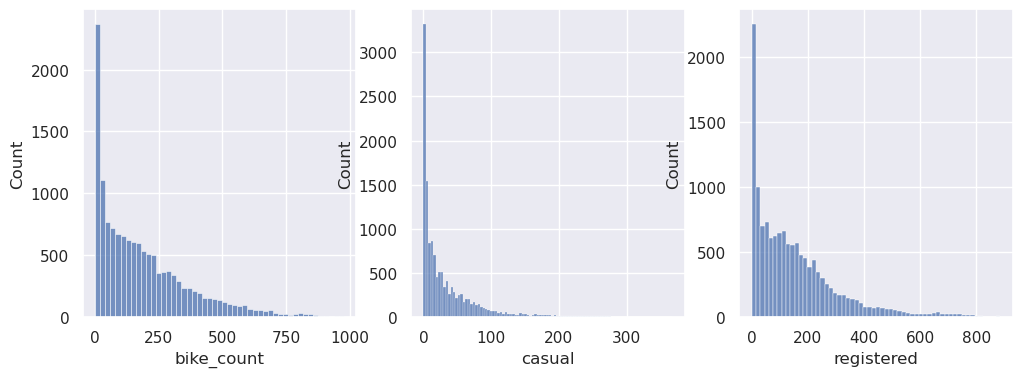

In [681]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(data=ytrain, x='bike_count', ax=ax[0])
sns.histplot(data=ytrain, x='casual', ax=ax[1])
sns.histplot(data=ytrain, x='registered', ax=ax[2])

plt.show()

Our targets are clearly all skewed to the left. This is not good as building a model with skewed targets can lead to bias. The model can be very accurate at predicting the value in the skewed direction (so good at predicting when bike count, number of casual riders, and number of registered riders is low) and will be inaccurate at predicting the opposite skew direction. To fix thos, we need to normalise the targets. We can use a number of methods, but here we can use log transform. Log transformation works by applying a logarithmic function to each value in the dataset, replacing that value by its logarithm, according to the base of the log func being used. This will normalize our targets before we use forward selection!

In [682]:
# Need to deal with new nans and negative inf values which are now present after transformation
ytrain.replace([np.inf, -np.inf], np.nan, inplace=True)
ytrain['bike_count'].fillna(ytrain['bike_count'].mean(), inplace=True)
ytrain['registered'].fillna(ytrain['registered'].mean(), inplace=True)
ytrain['casual'].fillna(ytrain['casual'].mean(), inplace=True)

Using Log transform below, adding +1 as performing log transformation on a zero value will result in -inf values.

In [683]:
ytrain['bike_count'] = np.log(ytrain['bike_count'] + 1)
ytrain['registered'] = np.log(ytrain['registered'] + 1)
ytrain['casual'] = np.log(ytrain['casual'] + 1)

Now that they have been log transfored, we can plot them to ensure they aren't as skewed.

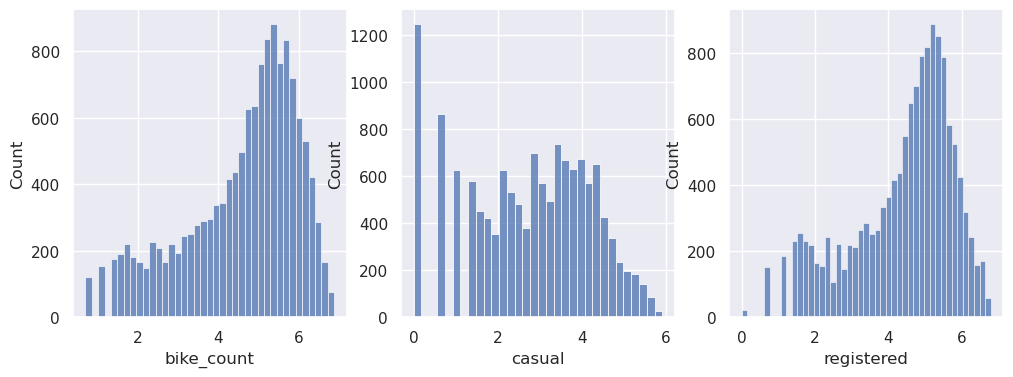

In [684]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(data=ytrain, x='bike_count', ax=ax[0])
sns.histplot(data=ytrain, x='casual', ax=ax[1])
sns.histplot(data=ytrain, x='registered', ax=ax[2])

plt.show()

Great. We can now use the code provided by credit balance lab to run through all of the targets and features to find the best predictors for each target.

### Forward Selection
Forward selection is a feature selection method that starts with an empty set of features and adds features to the set one at a time, based on some evaluation criterion, until the desired level of performance is reached. This process is repeated until all features have been added to the set and the performance is at its maximum. Since there is a larger number of features here, we can complete this task with the use of code.

In [685]:
model = linear_model.LinearRegression()

In [686]:
def find_next_best_predictor(X, found_predictors, column):
    all_predictors = list(X)
    predictors_to_search = set(all_predictors) - set(found_predictors)
    max_score = 0

    for predictor in predictors_to_search:
        trial_predictors = set(found_predictors)
        trial_predictors.add(predictor)
        x_col_subset = X.loc[:,list(trial_predictors)]
        model.fit(x_col_subset, column)
        current_score = model.score(x_col_subset, column)

        if current_score > max_score:
            max_score = current_score
            new_best_predictor_found = predictor

    return max_score, new_best_predictor_found


def predict_scores(predict_features, target):
    np = predict_features.shape[1]
    new_scores = [0]
    new_found_predictors = list()
    for i in range(np):
        (new_score, new_best_predictor_found) = find_next_best_predictor(predict_features, new_found_predictors, target)
        new_found_predictors.append(new_best_predictor_found)
        new_scores.append(new_score)

    print(new_found_predictors)
    print(new_scores)
    return new_scores

The above functions will find the best predictors in order for each target inputted.
The below code runs through each target column, calculates the best predictors, and print the values. Lastly it plots a line for each target. This will help us decide which target will be easiest to predict.

['hour', 'feels-like-temp', 'year', 'winter', 'weather_situation', 'windspeed', 'autumn', 'friday', 'saturday', 'sunday', 'thursday', 'spring', 'wednesday', 'monday', 'summer', 'tuesday']
[0, 0.32011009611039554, 0.4193258698860616, 0.4450196608558483, 0.4558686061345354, 0.46252983256183244, 0.4689070277537909, 0.47047409780655347, 0.47172123519605236, 0.47272237833872055, 0.47294047989031407, 0.4730905217064513, 0.4731276583608305, 0.4731623555520834, 0.4731623656450321, 0.4731623656450321, 0.473162365645032]
['hour', 'feels-like-temp', 'year', 'winter', 'windspeed', 'weather_situation', 'friday', 'autumn', 'sunday', 'monday', 'thursday', 'wednesday', 'saturday', 'summer', 'spring', 'tuesday']
[0, 0.32283882675089415, 0.3966916096404699, 0.42690996344763465, 0.4392350131517626, 0.44478416486303995, 0.4502092036792451, 0.4520661158259581, 0.4528744923835387, 0.45336738168258117, 0.45372081076124215, 0.4538381236678525, 0.45390235052993444, 0.4539130190606899, 0.4539165373373101, 0.453

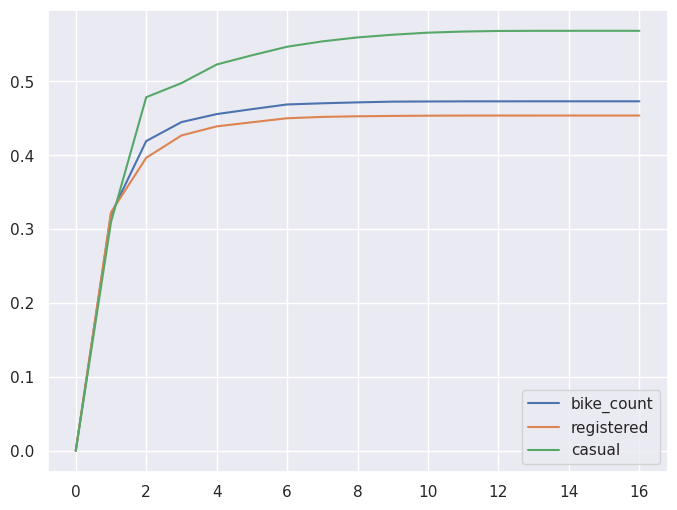

In [687]:
plt.figure(figsize=(8, 6))

for col in ytrain.columns:
    # Convert the column to a numeric array
    col_values = ytrain[col].values
    scores = predict_scores(xtrain, col_values)
    plt.plot(scores)

labels = ytrain.columns
plt.legend(labels)

From the three above, the features we could definitely keep as they are the strongest predictors are hour, feels-like-temp, year. It is generally a good idea to remove any columns that are not useful for making predictions before fitting a machine learning model. This can help to improve the performance of the model. However, in some cases, it might be useful to wait until after fitting the model to determine which columns are not useful for making predictions. For example, if using a regularization method such as Lasso or Ridge regression, the model will automatically identify and remove the columns that are not useful for making predictions. In this case, it might be best to wait until after fitting the model to remove the unnecessary columns, as this can make the model more interpretable and help you understand which columns are most important for making predictions.

### Scaling and Regression Models
After forward selection, it is common to scale the data before training a model on the selected features. This is because many machine learning algorithms, including linear regression, require that the features have similar scales in order to work properly.


If the scales of the features are very different, then some features may dominate the others during training, leading to poor model performance. For example, if one feature has values in the range 0 to 1, and another feature has values in the range 0 to 100,000, then the second feature will dominate the first feature during training, and the model may not be able to learn useful patterns from the first feature. I would also like to try a couple of different types of scalers to see which one performs the best!

#### Standardization
Standardization scaling is often recommended for regression methods that use regularization, such as ridge regression and lasso regression. This is because standardization scaling can help to ensure that the features are on the same scale, which can improve the performance of the regularization term and prevent the model from being overly sensitive to the magnitude of the coefficients. We can test this method of scaling in conjunction with those two types of regression.

This method scales the features by subtracting the mean of the feature and dividing by the standard deviation, so that the resulting distribution has a mean of 0 and a standard deviation of We'll do this for both the training and the testing data as using just the training data can be misleading

In [688]:
from sklearn.preprocessing import StandardScaler

# Transform the xtrain and xtest data using the scaler (fitting it to xtrain)
standard_scaler = StandardScaler()
xtrain_standard_scaled = standard_scaler.fit_transform(xtrain)
xtest_standard_scaled = standard_scaler.transform(xtest)

# Convert the scaled data back to dataframes
xtrain_scaled_df = pd.DataFrame(xtrain_standard_scaled, index=xtrain.index, columns=xtrain.columns)
xtest_scaled_df = pd.DataFrame(xtest_standard_scaled, index=xtest.index, columns=xtest.columns)

The negative coefficients in the model indicate that the features with negative coefficients have a negative relationship with the targets. In other words, as the values of the features with negative coefficients increase, the values of the targets are likely to decrease. This is not necessarily a problem, and it may be expected given the structure of the data and the relationships between the features and targets.

However, if the negative coefficients are causing the model to make poor predictions, this could indicate that the model is not well-suited to the data. In this case, we could try scaling the data using a different method to see if these changes improve the performance of the model. We could also try using cross-validation to evaluate the performance of the model and see if the negative coefficients are causing the model to make poor predictions on the validation set. This can help to identify any problems with the model and determine the best way to improve its performance.

**NOTE**: The scale of the yaxis in the plot below is a little wrong, but conveys the data nonetheless.

BIKE_COUNT 
 weather_situation   -0.118304
autumn              -0.091067
monday              -0.026793
tuesday             -0.026722
spring              -0.025239
wednesday           -0.017499
summer              -0.012528
thursday            -0.005317
sunday               0.002425
saturday             0.030502
friday               0.042850
windspeed            0.109969
winter               0.130718
year                 0.224043
feels-like-temp      0.509592
hour                 0.717107
dtype: float64 

REGISTERED 
 weather_situation   -0.105530
autumn              -0.078407
sunday              -0.034872
spring              -0.028564
summer              -0.025109
monday              -0.025075
tuesday             -0.009183
saturday            -0.003384
wednesday            0.006434
thursday             0.014150
friday               0.051641
windspeed            0.105675
winter               0.133937
year                 0.240465
feels-like-temp      0.431916
hour                 0.7203

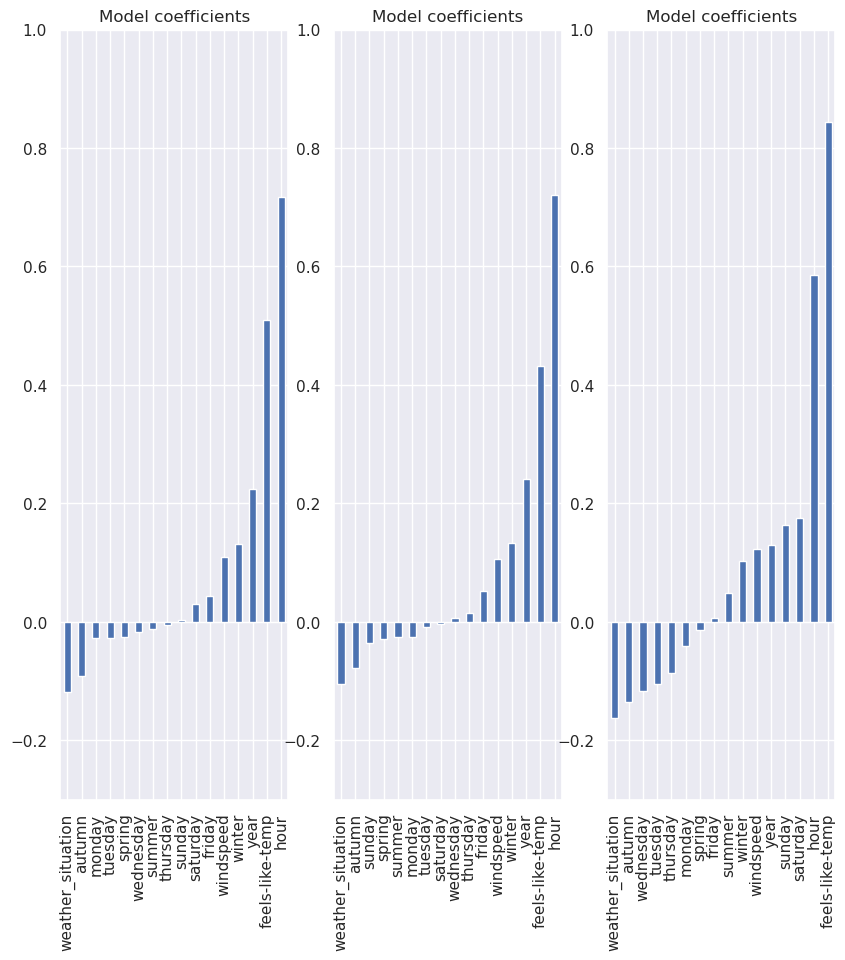

In [689]:
fig, ax = plt.subplots(1, 3, figsize=(10,10))

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytrain.columns):
    ax[i].set_ylim(bottom=-0.3) # Needed to set a limit on the negative values so that it is possible to view the positive values.
    col_values = ytrain[col].values
    model.fit(xtrain_scaled_df, col_values)

    predictors = xtrain_scaled_df.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

The plot shows that many of the predictors have negative coefficients, which indicates that they have a negative relationship with the target variable. This means that an increase in these predictors would lead to a decrease in the target variable.

To contrast, the test data shows a truer picture below.

BIKE_COUNT 
 saturday            -2.960661e+15
friday              -2.953304e+15
thursday            -2.951458e+15
wednesday           -2.950843e+15
sunday              -2.945910e+15
monday              -2.941580e+15
tuesday             -2.913443e+15
autumn              -2.782791e+14
summer              -2.778977e+14
winter              -2.731179e+14
spring              -2.725141e+14
weather_situation   -1.642035e+01
windspeed            1.184400e+01
year                 4.192119e+01
hour                 5.926449e+01
feels-like-temp      6.435504e+01
dtype: float64 

REGISTERED 
 saturday            -2.186432e+15
friday              -2.180998e+15
thursday            -2.179636e+15
wednesday           -2.179181e+15
sunday              -2.175538e+15
monday              -2.172340e+15
tuesday             -2.151561e+15
autumn              -2.055076e+14
summer              -2.052259e+14
winter              -2.016961e+14
spring              -2.012501e+14
weather_situation   -1.251207e+01
winds

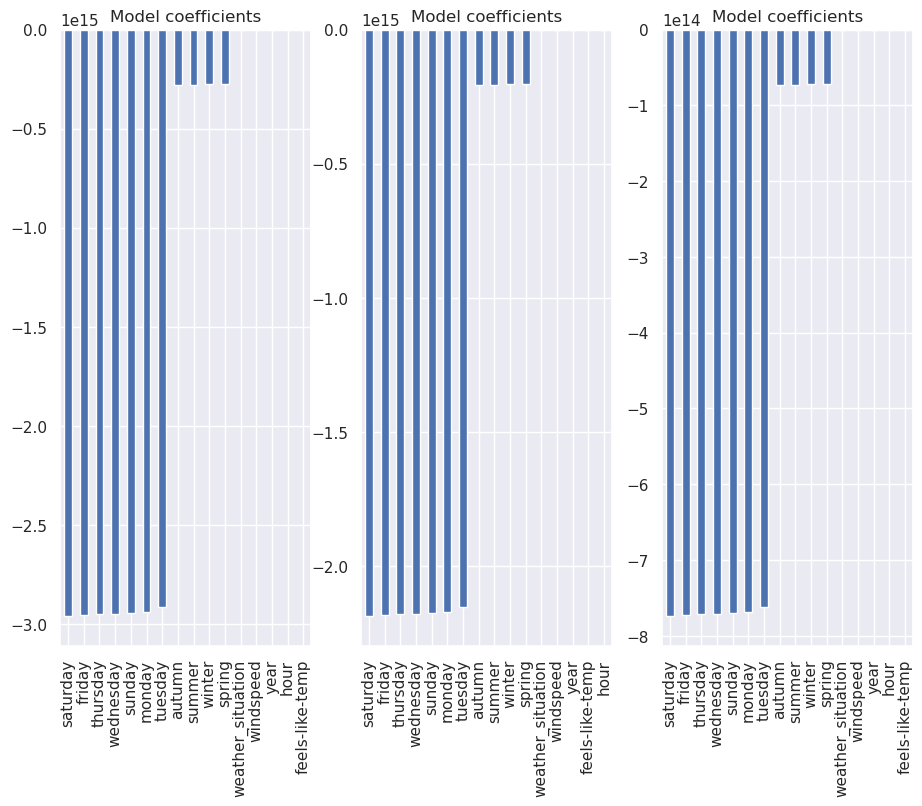

In [690]:
fig, ax = plt.subplots(1, 3)

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytest.columns):
    col_values = ytest[col].values
    model.fit(xtest_scaled_df, col_values)

    predictors = xtest_scaled_df.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

Before I continue, I am happy to drop the very badly performing features above to try narrow down our search for the best predictors.

BIKE_COUNT 
 sunday             -3.873511
wednesday          -1.366396
thursday            0.915188
friday              1.303367
windspeed          12.848886
winter             19.269240
year               42.175948
hour               58.856169
feels-like-temp    64.781152
dtype: float64 

REGISTERED 
 sunday            -10.900542
friday              2.977607
wednesday           3.881720
thursday            5.854250
windspeed           8.101364
winter             17.544209
year               35.290299
feels-like-temp    43.615054
hour               47.363268
dtype: float64 

CASUAL 
 wednesday          -5.248116
thursday           -4.939063
friday             -1.674240
winter              1.725032
windspeed           4.747522
year                6.885649
sunday              7.027031
hour               11.492901
feels-like-temp    21.166098
dtype: float64 



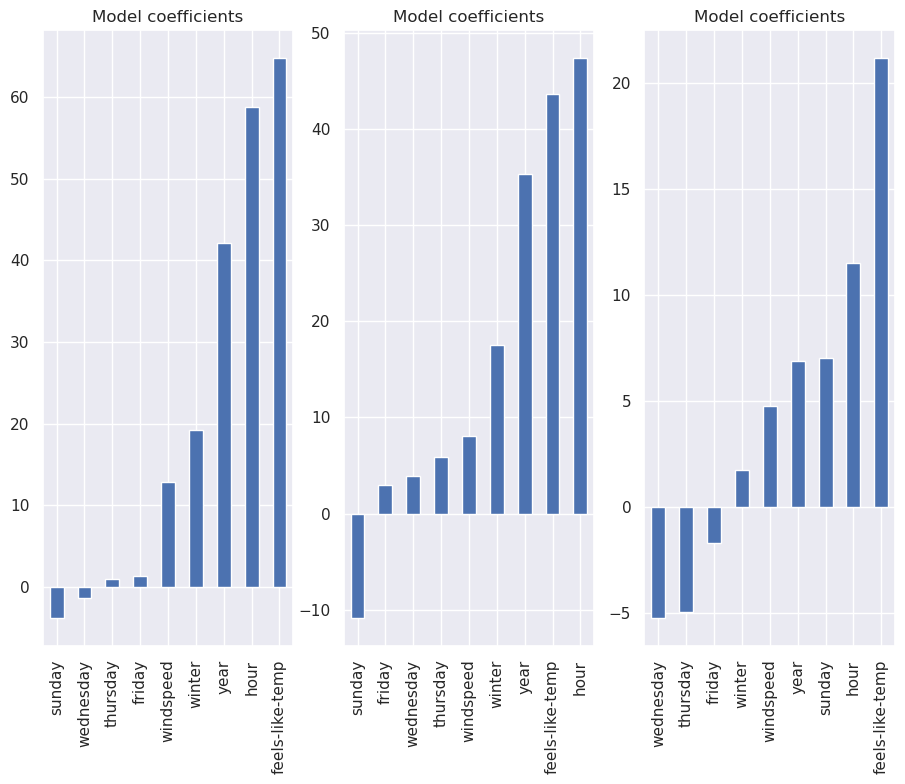

In [691]:
xtrain.drop(['weather_situation', 'autumn', 'spring', 'monday', 'tuesday', 'summer', 'saturday'], axis=1, inplace=True)
xtest.drop(['weather_situation', 'autumn', 'spring', 'monday', 'tuesday', 'summer', 'saturday'], axis=1, inplace=True)

# Transform the xtrain and xtest data using the scaler (fitting it to xtrain)
standard_scaler = StandardScaler()
xtrain_standard_scaled = standard_scaler.fit_transform(xtrain)
xtest_standard_scaled = standard_scaler.transform(xtest)

# Convert the scaled data back to dataframes
xtrain_scaled_df = pd.DataFrame(xtrain_standard_scaled, index=xtrain.index, columns=xtrain.columns)
xtest_scaled_df = pd.DataFrame(xtest_standard_scaled, index=xtest.index, columns=xtest.columns)


# Taking another look at the coef plot
fig, ax = plt.subplots(1, 3)

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytest.columns):
    col_values = ytest[col].values
    model.fit(xtest_scaled_df, col_values)

    predictors = xtest_scaled_df.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

#### Lasso Regression
We can now perform lasso regression to try deal with the last unwanted features.

In [692]:
from sklearn.linear_model import Ridge

# assign lambda (or alpha as is used in Ridge())
ridgeReg = Ridge(alpha=50)

# Now compute the ridge regression using X, the full matrix of predictors, and y
ridgeReg.fit(xtest_scaled_df, ytest)

ridgeReg.score(xtest_scaled_df, ytest)

0.32246030432269

#### Min-Max Scaling
This method scales the features by transforming them so that they have the minimum and maximum values specified by the user. This can be useful for ensuring that all of the features are on the same scale and have the same range of values.

['hour', 'feels-like-temp', 'year', 'winter', 'windspeed', 'friday', 'sunday', 'wednesday', 'thursday']
[0, 0.32011009611039554, 0.4193258698860616, 0.4450196608558483, 0.4558686061345354, 0.46190989036631724, 0.4631370893834402, 0.46326894937277197, 0.46335214613214737, 0.46336119405610643]
['hour', 'feels-like-temp', 'year', 'winter', 'windspeed', 'friday', 'thursday', 'sunday', 'wednesday']
[0, 0.32283882675089415, 0.3966916096404699, 0.42690996344763465, 0.4392350131517626, 0.44478416486303995, 0.4466354401829129, 0.4470540969052904, 0.44728566695887395, 0.44741459723834354]
['feels-like-temp', 'hour', 'sunday', 'year', 'windspeed', 'winter', 'wednesday', 'thursday', 'friday']
[0, 0.30948114934477056, 0.4786889407041579, 0.49638419088078256, 0.5044551537686957, 0.5107189495888707, 0.5165866028553431, 0.5218688945709475, 0.5255483949036408, 0.5255584898591372]


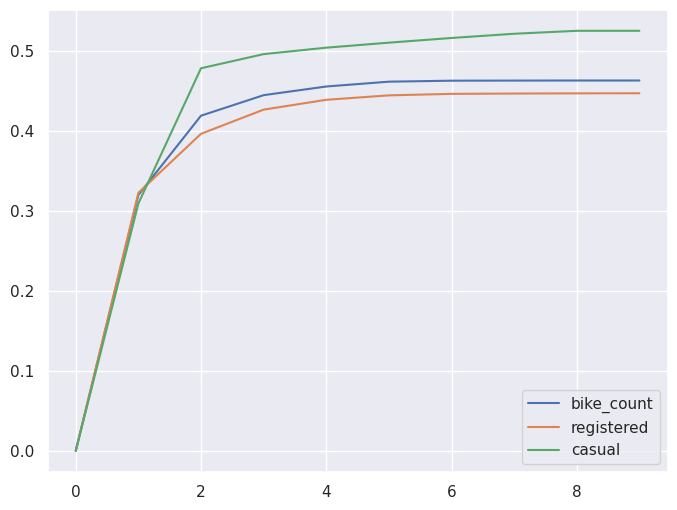

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaled_xtrain_array = scaler.fit_transform(xtrain) # Note that X is no longer a dataframe after scaling :-(
standard_scaled_xtrain = pd.DataFrame(scaled_xtrain_array, index=xtrain.index, columns=xtrain.columns) # Convert it back

In [ ]:
fig, ax = plt.subplots(1, 3)

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytrain.columns):
    col_values = ytrain[col].values
    model.fit(standard_scaled_xtrain, col_values)

    predictors = standard_scaled_xtrain.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

From the above:
- There is quite a large difference in the sensitivity of the regression between year and the other features. There is not much difference between the top two predictors though which is good.
- Would be interesting to check how the non scaled version fares. I would suspect this different would be far larger.

In [ ]:
fig, ax = plt.subplots(1, 3)

# Use the enumerate() function to get the index and value of each column
for i, col in enumerate(ytrain.columns):
    col_values = ytrain[col].values
    model.fit(xtrain, col_values)

    coef = pd.Series(model.coef_, xtrain.columns).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")


The difference with the non spread data is far larger as we can see above. It would be interesting to now see the difference of the scores now with the scaled data.

In [ ]:
plt.figure(figsize=(8, 6))

for col in ytrain.columns:
    # Convert the column to a numeric array
    col_values = ytrain[col].values
    scores = predict_scores(scaled_xtrain, col_values)
    plt.plot(scores)

labels = ytrain.columns
plt.legend(labels)

Looks like it didn't make much of a difference. Casual still looks to be the best predictor out of the three.

We could also try to use a different scaling method to see if it makes a difference, but I don't think it's worth the extra effort as I'm happy with the result above.

In [ ]:
# keep_columns = ['hour', 'feels-like-temp', 'year']
# # Drop all columns except for the specified columns
# xtrain.drop([col for col in xtrain.columns if col not in keep_columns], axis=1, inplace=True)
# xtrain.info()

As a note, in general a higher R-squared value is better, as it indicates that the model is able to explain more of the variance in the data. However, a high R-squared value does not necessarily imply that the model is a good fit for the data, as the model may be overfitting the data. It is important to evaluate the model using additional metrics to determine its overall quality. 10 fold cross validation, as described in the assignment spec, will help with this later to estimate the uncertainty of the model's parameters.

### Regression Model

# Task 4: Which of the 3 target columns is easiest to predict accurately?

Of the three, it looks like casual is easiest to predict.

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label

##Start of Answer 5##

##End of Answer 5##

# Task 6: Use _two_ classification procedures to predict these demand quartiles

##Start of Answer 6

##End of Answer 6##

# Task 7: Which of the two machine learning procedures provides the highest prediction accuracy on the test set?

##Start of Answer 7

##End of Answer 7##